# **TP: Implémentation d’une cascade de régresseurs pour l’alignement de points caractéristiques du visage**
- **Nom: Massyl Yanis HAMDI**
- **Num: 21118208**

## **Description**

L’objectif de ce TP est de réaliser une méthode d’alignement de points caractéristiques du visage inspirée de [1]. À l’issue du TP, vous devez fournir un notebook jupyter contenant :


## **1 Préparation des données**

##### **1.1 Téléchargement des données**



La base est constituée de 4 sous-ensembles de données (Helen, AFW, LFPW et iBug) dont les images (extension .jpg ou .png) et les annotations (extension .pts) sont contenues dans les répertoires du même nom. On a également des fichiers .txt contenant la liste des données à utiliser pour l'apprentissage - 300w_train_images.txt et 300w_train_landmarks.txt respectivement pour la liste des images et des annotations - ainsi que pour les tests.

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random

# Initialisation des listes vides pour stocker les images et les repères (landmarks)
images = []
landmarks = []

# Ouvre les fichiers contenant les chemins des images et des repères
with open('datasets/300w_train_images.txt', 'r') as path_images, open('datasets/300w_train_landmarks.txt', 'r') as path_keypoints:
    # Parcours les lignes des deux fichiers en même temps
    for pathimg, pathkey in zip(path_images, path_keypoints):
        # Construit les chemins complets vers les images et les repères
        path = 'datasets/' + pathimg.strip()
        landmark = 'datasets/' + pathkey.strip()
        
        # Charge l'image depuis le chemin
        img = io.imread(path)
        
        # Ajoute l'image à la liste des images
        images.append(io.imread(path))
        
        # Charge les repères depuis le fichier et les ajoute à la liste des repères
        landmarks.append(np.loadtxt(landmark))


##### **1.2 Visualisation des données**

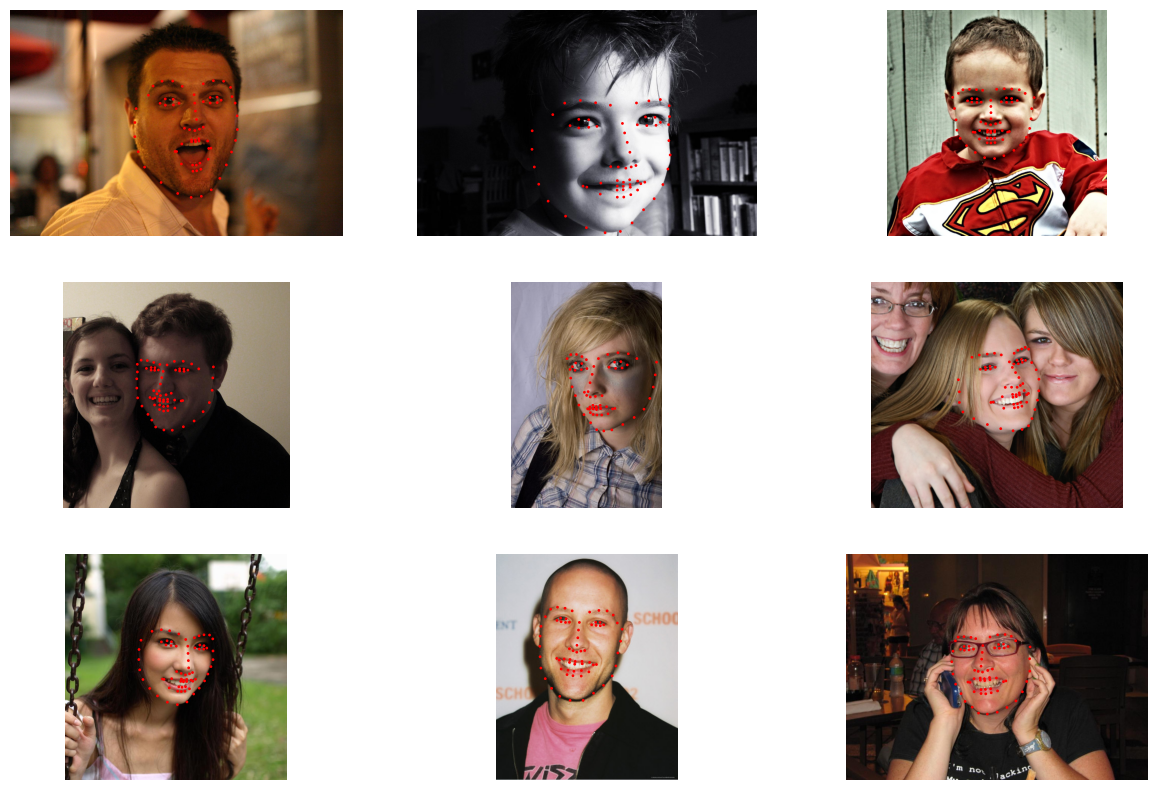

In [5]:
# On génère une liste d'indices d'images aléatoires de 0 à 3147 (3148 images au total), puis on les trie.
index = sorted(random.sample(range(len(images)), 9))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i, ind in enumerate(index):
    ax[(i//3), (i % 3)].imshow(images[ind], cmap='gray')
    key = landmarks[ind]
    # On affiche les repères en utilisant un nuage de points 
    ax[(i//3), (i % 3)].scatter(key[:, 0], key[:, 1], s=1, facecolors='none', edgecolors='r')
    ax[(i//3), (i % 3)].axis('off')


##### **1.3 Augmentation des données**

1.Calculer les paramètres de la boite englobante des points caractéristiques du visage

In [36]:
def bounding_box(keypoints, Expand_percent = None):
    """
    Calcule une boîte englobante autour des repères.

    Args:
        keypoints (numpy.ndarray): Tableau de repères avec deux colonnes représentant les coordonnées x et y.
        Expand_percent (int, facultatif): Pourcentage d'expansion de la boîte englobante. Par défaut, None.

    Returns:
        tuple: Un tuple contenant les informations de la boîte englobante : (coin_sup_gauche, largeur, hauteur, coin_inf_droit).
    """

    if isinstance(Expand_percent, int):
        Expand_percent = (Expand_percent/100) / 2
    else:
        Expand_percent = 0
        
    # Calcul des coordonnées du coin supérieur gauche de la boîte englobante
    coin_sup_gauche = (
        keypoints[:, 0].min() - keypoints[:, 0].min() * Expand_percent,
        keypoints[:, 1].min() - keypoints[:, 1].min() * Expand_percent
    )

    # Calcul des coordonnées du coin inférieur droit de la boîte englobante
    coin_inf_droit = (
        keypoints[:, 0].max() + keypoints[:, 0].min() * Expand_percent,
        keypoints[:, 1].max() + keypoints[:, 1].min() * Expand_percent
    )

    # Calcul de la largeur et de la hauteur de la boîte englobante
    largeur = coin_inf_droit[0] - coin_sup_gauche[0]
    hauteur = coin_inf_droit[1] - coin_sup_gauche[1]

    return coin_sup_gauche, largeur, hauteur, coin_inf_droit

Affichage de quelque boite englobante des points caractéristiques du visage

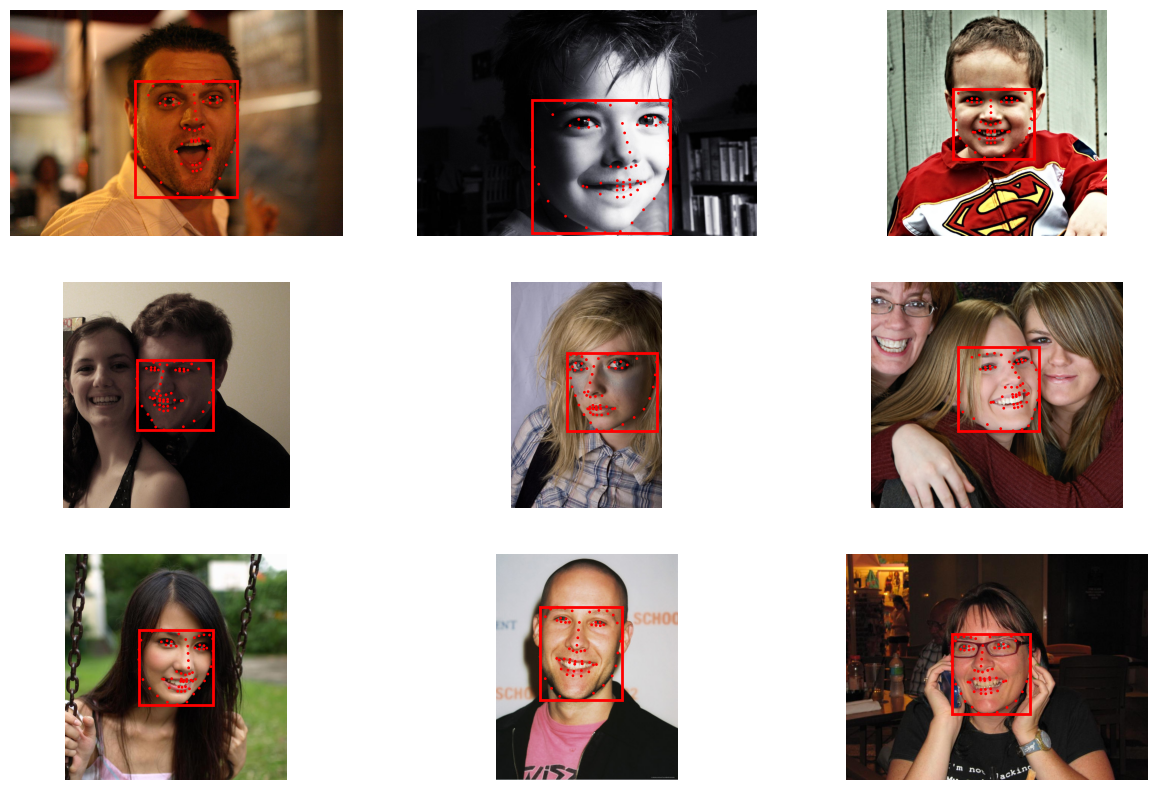

In [37]:
import matplotlib.patches as patches


# Crée une grille de sous-graphiques de 3 lignes et 3 colonnes avec une taille de figure spécifiée
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Itère sur les indices sélectionnés aléatoirement
for i, ind in enumerate(index):
    ax[(i//3), (i % 3)].imshow(images[ind], cmap='gray')
    key = landmarks[ind]
    ax[(i//3), (i % 3)].scatter(key[:, 0], key[:, 1], s=1, facecolors='none', edgecolors='r')
    # Calcule les informations de la boîte englobante
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(key)
    rect = patches.Rectangle(coin_sup_gauche, largeur, hauteur, linewidth=2, edgecolor='r', facecolor='none')
    ax[(i//3), (i % 3)].add_patch(rect)
    ax[(i//3), (i % 3)].axis('off')


2. Élargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, redimensionner l’image en 128 ∗ 128 et enregistrer l’image.

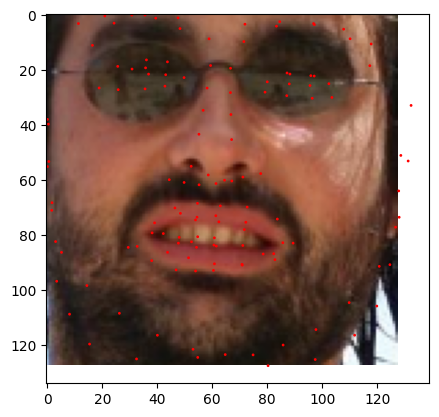

In [46]:
import os
import glob
import cv2

save_dir = "./datasets/data_processing"
os.makedirs(save_dir, exist_ok=True)
for i in range(2):
    new_fname = f"{str(i)}.jpg"
    small_fname = os.path.join(save_dir, new_fname)
    # cv2.imwrite(small_fname, img_small)
    key = landmarks[i]
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(key)
    new_keypnt  = np.column_stack((np.array(key[:, 0]) - coin_sup_gauche[0], np.array(key[:, 1]) - coin_sup_gauche[1]))
    # print()
    new_image = images[i]
    # print(new_image.shape)
    new_image = new_image[int(coin_sup_gauche[1]):int(coin_inf_droit[1]), int(coin_sup_gauche[0]):int(coin_inf_droit[0])]
    # print(new_image.shape)
    image_resized = cv2.resize(new_image, (128, 128))
    # print(image_resized.shape)
    image_width, image_height, _ = new_image.shape
    newsize_w, newsize_h, _ = image_resized.shape
    w_factor = image_width / newsize_w
    h_factor =  image_height / newsize_h
    plt.imshow(image_resized)
    plt.scatter(new_keypnt[:,0]/w_factor, new_keypnt[:,1]/h_factor,s =1, facecolors='none', edgecolors='r')

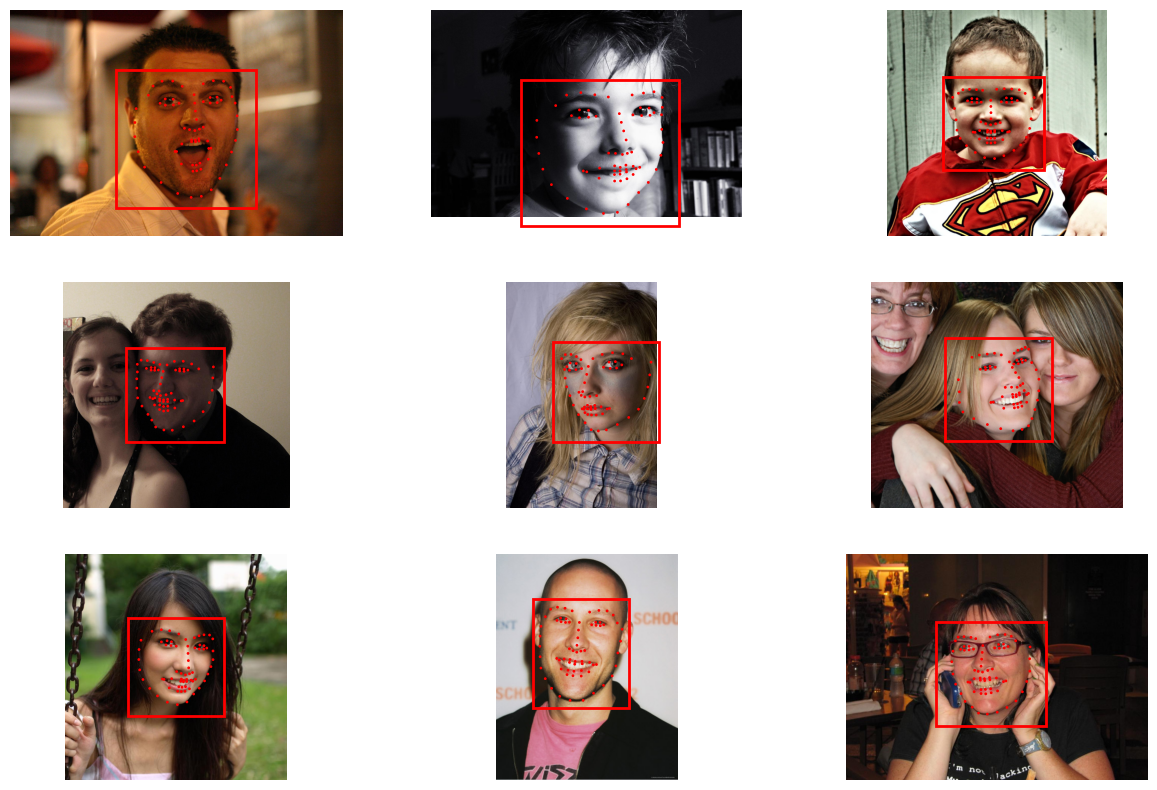

In [38]:
# Crée une grille de sous-graphiques de 3 lignes et 3 colonnes avec une taille de figure spécifiée
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Itère sur les indices sélectionnés aléatoirement
for i, ind in enumerate(index):
    ax[(i//3), (i % 3)].imshow(images[ind], cmap='gray')
    key = landmarks[ind]
    ax[(i//3), (i % 3)].scatter(key[:, 0], key[:, 1], s=1, facecolors='none', edgecolors='r')
    # Calcule les informations de la boîte englobante
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(key, Expand_percent = 30)
    rect = patches.Rectangle(coin_sup_gauche, largeur, hauteur, linewidth=2, edgecolor='r', facecolor='none')
    ax[(i//3), (i % 3)].add_patch(rect)
    ax[(i//3), (i % 3)].axis('off')